In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.data as dpd
import nibabel as nib

We'll use [multi b-value data](https://digital.lib.washington.edu/researchworks/handle/1773/33311) kindly provided by Romain Valabregue (CENIR) 

In [3]:
img, gtab = dpd.read_cenir_multib()

All files already in /Users/arokem/.dipy/cenir_multib.


In [4]:
data = img.get_data()

For this example, we will look at data from three different voxels, that were randomly chosen from corpus callosum (cc), gray matter (gm) and the centrum semiovale region (cso):

In [5]:
cc_idx = (52, 42, 40)
gm_idx = (76, 52, 55)
cso_idx = (65, 52, 49)

We'll use non-diffusion-weighted normalized signals for fitting and for error estimates

In [6]:
data_cc = data[cc_idx] / np.mean(data[cc_idx][gtab.b0s_mask])
data_gm = data[gm_idx] / np.mean(data[gm_idx][gtab.b0s_mask])
data_cso = data[cso_idx] / np.mean(data[cso_idx][gtab.b0s_mask])               

In [8]:
def exponential(x, D):
    return np.exp(-x * D)

In [9]:
def biexponential(x, D1, beta1, D2, beta2):
    return beta1 * np.exp(-x * D1) + beta2 * np.exp(-x * D2)

In [10]:
def exponential_with_noise_floor(x, D, C):
    return np.exp(-x * D) + C

In [11]:
def err_func(params, x, y, func):
        """
        Error function for fitting a function
        
        Parameters
        ----------
        params : tuple
            A tuple with the parameters of `func` according to their order of input

        x : float array 
            An independent variable. 
        
        y : float array
            The dependent variable. 
        
        func : function
            A function with inputs: `(x, *params)`
        
        Returns
        -------
        The marginals of the fit to x/y given the params
        """
        return y - func(x, *params)

In [12]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

In [13]:
from sklearn.cross_validation import KFold
import scipy.optimize as opt

In [20]:
def run_cross_validation(x, y, func):
    # Construct a kfolds object
    kf = KFold(len(y), n_folds=5)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train = y[train_index]
        initial = tuple(np.zeros(func.func_code.co_argcount-1))
        params, _ = opt.leastsq(err_func, initial, args=(x_train, y_train, func))
        y_pred[test_index] = func(x_test, *params)
    return y_pred, params

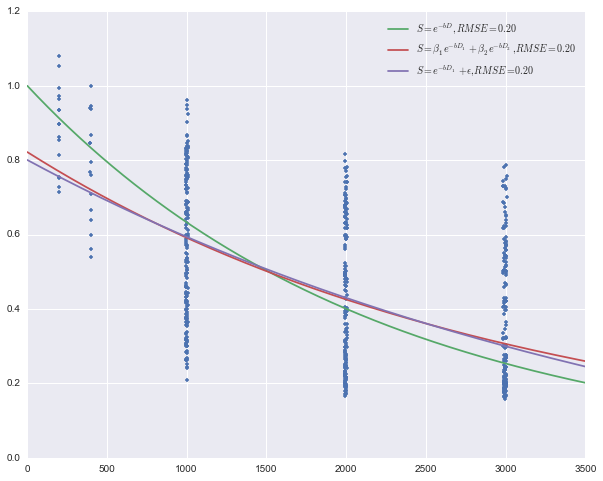

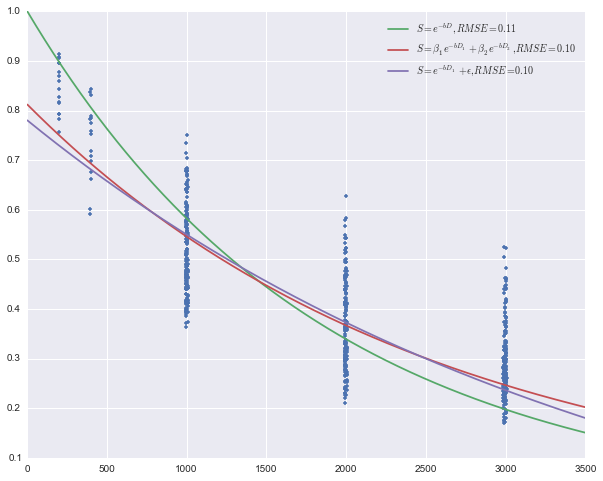

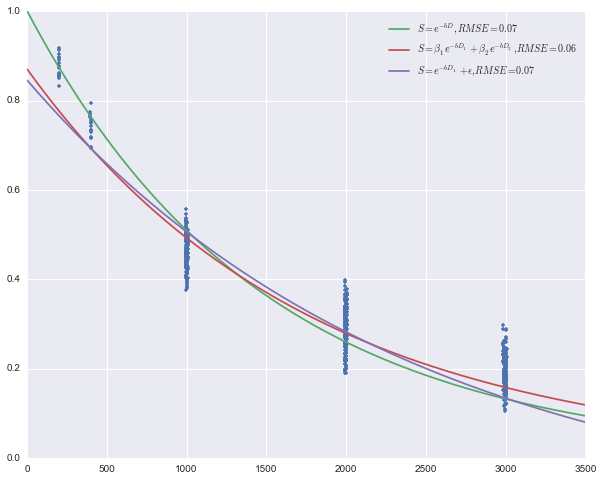

In [23]:
for this_data in data_cc[~gtab.b0s_mask], data_cso[~gtab.b0s_mask], data_gm[~gtab.b0s_mask]:
    #for func in [exponential, biexponential]
    y_pred_exponential, params_exponential = run_cross_validation(gtab.bvals[~gtab.b0s_mask], this_data, exponential)
    y_pred_biexponential, params_biexponential = run_cross_validation(gtab.bvals[~gtab.b0s_mask], this_data, biexponential)
    y_pred_exponential_noise_floor, params_exponential_with_noise_floor = run_cross_validation(gtab.bvals[~gtab.b0s_mask], this_data, exponential_with_noise_floor)
    fig, ax = plt.subplots(1)
    bvals_for_plot = np.arange(0, 3500)
    plt.plot(gtab.bvals[~gtab.b0s_mask], this_data, '.')
    plt.plot(bvals_for_plot, exponential(bvals_for_plot, *params_exponential), label="$S=e^{-bD}, RMSE=%2.2f$"%rmse(this_data, y_pred_exponential))
    plt.plot(bvals_for_plot, biexponential(bvals_for_plot, *params_biexponential), label="$S= \\beta_1 e^{-bD_1} + \\beta_2 e^{-bD_2}, RMSE=%2.2f$"%rmse(this_data, y_pred_biexponential))
    plt.plot(bvals_for_plot, exponential_with_noise_floor(bvals_for_plot, *params_exponential_with_noise_floor), label="$S= e^{-bD_1} + \epsilon, RMSE=%2.2f$"%rmse(this_data, y_pred_exponential_noise_floor))

    fig.set_size_inches([10, 8])
    plt.legend()

In [24]:
idx_x = np.rad2deg(np.arccos(np.dot(gtab.bvecs, np.array([1, 0, 0])))) < 30
idx_z = np.rad2deg(np.arccos(np.dot(gtab.bvecs, np.array([0, 0, 1])))) < 30

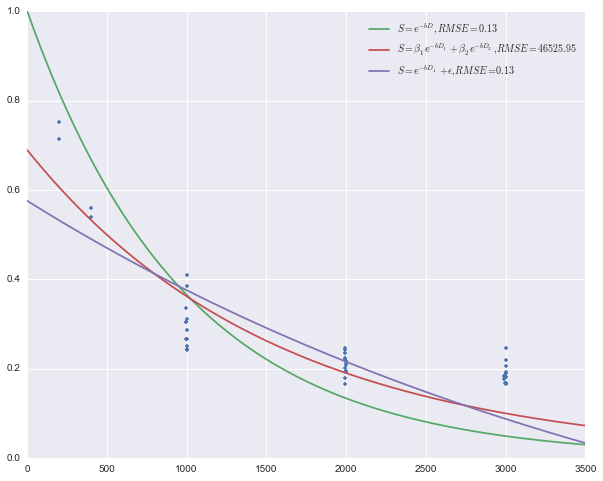

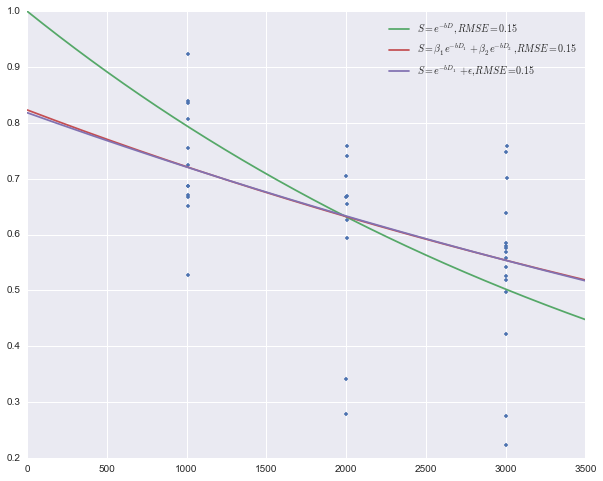

In [32]:
bvals_x = gtab.bvals[idx_x]
bvals_z = gtab.bvals[idx_z]
for this_data, this_bvals in zip([data_cc[idx_x], data_cc[idx_z]], [bvals_x, bvals_z]):
    #for func in [exponential, biexponential]
    y_pred_exponential, params_exponential = run_cross_validation(this_bvals, this_data, exponential)
    y_pred_biexponential, params_biexponential = run_cross_validation(this_bvals, this_data, biexponential)
    y_pred_exponential_noise_floor, params_exponential_with_noise_floor = run_cross_validation(this_bvals, this_data, exponential_with_noise_floor)
    fig, ax = plt.subplots(1)
    bvals_for_plot = np.arange(0, 3500)
    plt.plot(this_bvals, this_data, '.')
    plt.plot(bvals_for_plot, exponential(bvals_for_plot, *params_exponential), label="$S=e^{-bD}, RMSE=%2.2f$"%rmse(this_data, y_pred_exponential))
    plt.plot(bvals_for_plot, biexponential(bvals_for_plot, *params_biexponential), label="$S= \\beta_1 e^{-bD_1} + \\beta_2 e^{-bD_2}, RMSE=%2.2f$"%rmse(this_data, y_pred_biexponential))
    plt.plot(bvals_for_plot, exponential_with_noise_floor(bvals_for_plot, *params_exponential_with_noise_floor), label="$S= e^{-bD_1} + \epsilon, RMSE=%2.2f$"%rmse(this_data, y_pred_exponential_noise_floor))

    fig.set_size_inches([10, 8])
    plt.legend()